# Project 3: ML Regression


The notebook explains how to create a ML regression model to predict demand for bikesharing vehicles. Bikesharing data are available here: https://www.kaggle.com/c/bike-sharing-demand. The notebook was developed as as study project for the Spiced Academy Data Science Bootcamp.

## Imports

In [318]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

plt.rcdefaults()

## Business goal

Build a model that is able to predict the number of bikes rented (target variable "count" that sums the bikes rented by casual and registered users of the bikesharing service) according to the weather conditions.

## Reading data

In [244]:
train = './kaggle_data/train.csv'
df = pd.read_csv(train, parse_dates=True, index_col=0)

In [245]:
df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168


## Exploratory Data Analysis

In [246]:
#Checking if there are missing values in the dataframe. None in this case.
df.isnull().values.any()

False

In [247]:
# datatypes in the dataframe. Only integers and floats
df.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [248]:
#seasons examined. The data seems to be roughly equally distributed throughout the year
#(1=spring, 4=winter)
df['season'].value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

In [249]:
df['holiday'].value_counts()


0    10575
1      311
Name: holiday, dtype: int64

In [250]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

In [254]:
#create a column for the weekends to compare with holiday and working day rentals
df['weekend'] = df.apply(lambda x: 1 if (x['workingday'] == 0) &
                         (x['holiday'] == 0) else 0, axis=1)

In [257]:
df = df[['season', 'holiday', 'workingday', 'weekend', 'weather', 'temp', 'atemp', 
         'humidity','windspeed', 'casual', 'registered', 'count']]

In [258]:
df

,season,holiday,workingday,weekend,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,1,9.84,14.395,81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,0,1,1,9.02,13.635,80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,0,1,1,9.02,13.635,80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,0,1,1,9.84,14.395,75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,0,1,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,0,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,0,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,0,1,13.94,15.910,61,15.0013,4,164,168


In [ ]:
#Total number of casual and registered renters
registered = df['registered'].sum()
casual = df['casual'].sum()

print("Registered renters: ", registered)
print("Casual renters: ", casual)

In [ ]:
df.plot.scatter(x="temp", y="count", color = 'red');

In [ ]:
df.plot.scatter(x="atemp", y="count", color = 'grey');

In [ ]:
df.plot.scatter(x="humidity", y="count", color = 'green');

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)

sns.heatmap(round(df.corr(), 2), annot=True);


** The heatmap suggests that the target, i.e. the count column is actually correlated to the weather conditions and that the interesting features are temp (positive correlation), atemp(positive correlation, but not very informative as temp is already providing the information) and humidity (negative correlation). Holiday and working days do not seem to make any difference. In the linear regression I will therefore correlate temp (and humidity) with the count.

## Linear regression

In [264]:
X_train = df.drop(['casual', 'registered', 'count'], axis=1)

In [265]:
X_train 

,season,holiday,workingday,weekend,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,1,9.84,14.395,81,0.0000
2011-01-01 01:00:00,1,0,0,1,1,9.02,13.635,80,0.0000
2011-01-01 02:00:00,1,0,0,1,1,9.02,13.635,80,0.0000
2011-01-01 03:00:00,1,0,0,1,1,9.84,14.395,75,0.0000
2011-01-01 04:00:00,1,0,0,1,1,9.84,14.395,75,0.0000
...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,0,1,15.58,19.695,50,26.0027
2012-12-19 20:00:00,4,0,1,0,1,14.76,17.425,57,15.0013
2012-12-19 21:00:00,4,0,1,0,1,13.94,15.910,61,15.0013


In [266]:
y_train = df['count']

In [267]:
y_train

datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: count, Length: 10886, dtype: int64

### Feature engineering

In [319]:
trans = ColumnTransformer([
    ('one_hot_enc', OneHotEncoder(sparse=False, handle_unknown='ignore'), 
     ['season','holiday','workingday', 'weather']),
    ('scale', MinMaxScaler(), ['temp','atemp', 'humidity','windspeed'])
     ])
    

In [320]:
trans.fit(X_train, y_train)


ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('one_hot_enc',
                                 OneHotEncoder(categories='auto', drop=None,
                                               dtype=<class 'numpy.float64'>,
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['season', 'holiday', 'workingday',
                                  'weather']),
                                ('scale',
                                 MinMaxScaler(copy=True, feature_range=(0, 1)),
                                 ['temp', 'atemp', 'humidity', 'windspeed'])],
                  verbose=False)

In [321]:
X_train_transform = trans.transform(X_train)

In [322]:
X_train_transform

array([[1.        , 0.        , 0.        , ..., 0.30506768, 0.81      ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.28806354, 0.8       ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.28806354, 0.8       ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.33896409, 0.61      ,
        0.26319502],
       [0.        , 0.        , 0.        , ..., 0.3728605 , 0.61      ,
        0.10532503],
       [0.        , 0.        , 0.        , ..., 0.35585636, 0.66      ,
        0.15786999]])

In [323]:
model_lr = LinearRegression()

In [324]:
model_lr.fit(X_train_transform, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Cross validation

In [325]:
cross_validation = cross_validate(model_lr,
              X_train_transform,
              y_train,
              cv=10,
              return_train_score=True)

In [326]:
cross_validation['train_score'].mean()

0.27856319441340266

In [327]:
cross_validation['test_score'].mean()

-6.363672294615755e+18

In [328]:
model_lr.score(X_train_transform, y_train)

0.2767493521154366

In [329]:
y_pred = model_lr.predict(X_train_transform)

In [332]:
model_lr.intercept_

-421611503504571.94

In [333]:
model_lr.coef_

array([ 2.35810900e+13,  2.35810900e+13,  2.35810900e+13,  2.35810900e+13,
        2.62026159e+13,  2.62026159e+13, -5.45600702e+12, -5.45600702e+12,
        3.77283805e+14,  3.77283805e+14,  3.77283805e+14,  3.77283805e+14,
        3.26017551e+02,  1.23415200e+02, -2.80983934e+02,  3.38112757e+01])

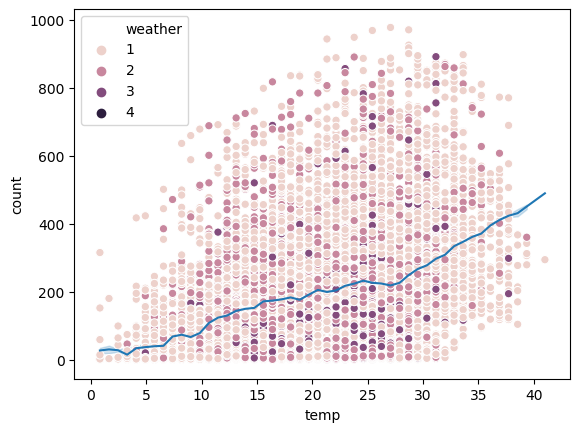

In [330]:
sns.lineplot(x=X_train['temp'], y=y_pred)
sns.scatterplot(x='temp', y=y_train, data=X_train, hue=df['weather'])

In [ ]:
df['weather'].value_counts().plot(kind ='barh')


In [ ]:
weather_lst = df['weather'].unique().tolist()

In [ ]:
weather_lst

In [ ]:
weather_casual = []
for weather in weather_lst:
    casual_n = df[df['weather']== weather]['casual'].sum()
    weather_casual.append(casual_n)
    
print(weather_casual)

In [ ]:
weather_registered = []
for weather in weather_lst:
    casual_n = df[df['weather']== weather]['registered'].sum()
    weather_registered.append(casual_n)
    
print(weather_registered)

In [ ]:
x = weather_lst
y1 = weather_casual
y2 = weather_registered

fig, axes = plt.subplots()
plt.bar(x,y1) 
plt.bar(x,y2) 
plt.legend(loc='best')
plt.xlabel('Weather conditions')
plt.ylabel('Bikesharing users')

In [ ]:
#Casual and registered rentals divided per weather condition
df.groupby('weather').plot()

## Feature Engineer

In [ ]:
X_train, y_train = feature_engineering(df)

## Train a model / multiple models

In [ ]:
m = LinearRegression()
m.fit(X_train,y_train)

## Model evaluation / model selection - Cross-Validation

Go back to EDA and Feature Engineering part to improve your model and only once you are happy with the results go on!

## Test on unseen data

In [ ]:
test = './data/test.csv'
df = pd.read_csv(test, parse_dates=True, index_col=0)

In [ ]:
X_test = feature_engineering(df, test=True)

In [ ]:
prediction_to_csv(X_test,m)